In [41]:
import utils
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from netgraph import Graph
import numpy as np
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
from sklearn.manifold import MDS
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
USA_data = pd.read_csv('data/USA/H116_filtered_USA_votes.csv')
PA,PAV,PAVP,PP = utils.dict_create(USA_data,'icpsr','party_code','rollnumber','cast_code')

In [4]:
U_thres = np.average(utils.calc_thres(PP, PA, PAV))
USA_inter= utils.calc_inter_edges(PP,PA,PAV)
U_edgelist = utils.edgelist_calc(PA, PAV, U_thres)
U_edgelist = (U_edgelist + USA_inter)
G_USA = nx.from_edgelist(U_edgelist)
list_of_dangle = [node for node in G_USA.nodes if G_USA.degree(node) == 0]
list_of_dangle

[]

In [5]:
# Create node to community mapping based on party codes
node_to_community = {}
party_to_community = {
    100: 0,  # Democrat
    200: 1,  # Republican 
    328: 2,  # Independent
}

for icpsr in PAVP:
    party_code = PAVP[icpsr][0][2]  # Get party code from first vote
    node_to_community[icpsr] = party_to_community.get(party_code, 3)  # Default 3 for other parties

# Color mapping
community_to_color = {
    0: 'blue',      # Democrats
    1: 'red',       # Republicans
    2: 'green',     # Independents
    3: 'gray'       # Others
}
node_color = {node: community_to_color[community_id] 
              for node, community_id in node_to_community.items()}



/opt/anaconda3/lib/python3.11/site-packages/netgraph/_node_layout.py:1621: UserWarning: There are no connections within community 2. The placement of of nodes within this community is arbitrary.
  warnings.warn(f"There are no connections within community {community}. The placement of of nodes within this community is arbitrary.")
/opt/anaconda3/lib/python3.11/site-packages/netgraph/_node_layout.py:1024: RuntimeWarning: invalid value encountered in divide
  directions = deltas / magnitudes[:, np.newaxis]
/opt/anaconda3/lib/python3.11/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


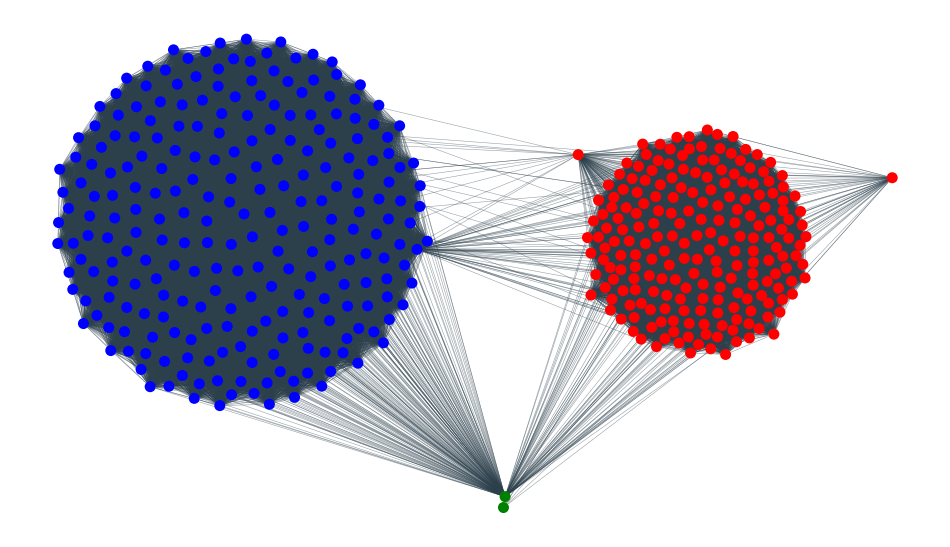

In [6]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
Graph(G_USA,
      node_color=node_color,
      node_edge_width=0,
      node_size=1,
      edge_width=0.1,
      edge_alpha=0.5,
      node_layout='community', 
      node_layout_kwargs=dict(node_to_community=node_to_community),
      ax=ax)
plt.show()

# PCA US 

In [264]:
from scipy.sparse import csr_matrix
import numpy as np

# Step 1: Extract unique people (rows) and bills (columns)
people = list(PAV.keys())  # List of people
votes = set()  # Store the distinct votes/bills

for voted_bills in PAV.values():
    for bill, _ in voted_bills:
        votes.add(bill)

votes = sorted(votes)  # Sort bills to ensure consistent column order
vote_to_index = {vote: idx for idx, vote in enumerate(votes)}  # Mapping from bill to column index

# Step 2: Construct the data for the sparse matrix
data = []
row_indices = []
col_indices = []

# Create a full zero matrix first to handle missing votes (0 = no vote)
num_people_us = len(PAV)
num_votes_us = len(votes)
sparse_matrix_us = np.zeros((num_people_us, num_votes_us))  # Initialize with 0 (no vote)

for person, voted_bills in PAV.items():
    for bill, vote in voted_bills:  # Iterate over list of (bill, vote) pairs
        row_idx = people.index(person)
        col_idx = vote_to_index[bill]

        if vote == 1:
            sparse_matrix_us[row_idx, col_idx] = 2  # "Yes" vote
        elif vote == 2:
            sparse_matrix_us[row_idx, col_idx] = 1  # "No" vote
        # Else, leave as 0 (no vote)



In [265]:
# Step 2: Apply TruncatedSVD (PCA for sparse matrix)
n_components = 2  # You can set the number of components (dimensions) to reduce to
pca = PCA(n_components=n_components)
US_reduced_matrix= pca.fit_transform(sparse_matrix_us)

# Step 3: Display the reduced matrix (lower dimensions)
print("Reduced Matrix (PCA Result):")
print(US_reduced_matrix)

# Optional: You can also check the amount of variance explained by each component
print("Explained variance ratio:")
print(pca.explained_variance_ratio_)

Reduced Matrix (PCA Result):
[[ -8.92794761   5.26666063]
 [-15.10157524   0.96435843]
 [ -9.14372928   7.4843416 ]
 [ -3.7216225    3.97055891]
 [ 12.26559701  -1.89183618]
 [ 11.47464032  -1.78339955]
 [ 11.67953578  -2.54314873]
 [ 12.41957278  -1.54738689]
 [ 10.38641215  -3.08229676]
 [  1.07294409  -7.67705309]
 [ 12.89364636  -1.6422576 ]
 [ -4.1111609    6.57385916]
 [-27.79902011 -31.55374503]
 [ 13.07200717  -1.53210462]
 [ 12.19629454  -2.01610637]
 [ 11.71260367  -1.91222638]
 [ 12.41228834  -1.70212009]
 [ 12.93347031  -1.27118236]
 [ 12.36529456  -1.62329924]
 [ 12.63130296  -1.48246819]
 [ 12.89159762  -1.41525321]
 [-10.60399703   6.90182823]
 [ 12.63926561  -1.30824041]
 [-10.86508941   6.83174145]
 [ 12.6739445   -1.51994261]
 [ 10.87655131  -3.07736048]
 [-11.00012682   5.86218373]
 [ 10.16364653  -5.68465987]
 [ -9.53886706   8.50906149]
 [ 11.60002692  -2.60113792]
 [ -7.49042047   6.96614997]
 [ 12.21291656  -1.82788632]
 [ 12.20668042  -1.09673196]
 [-12.59051161

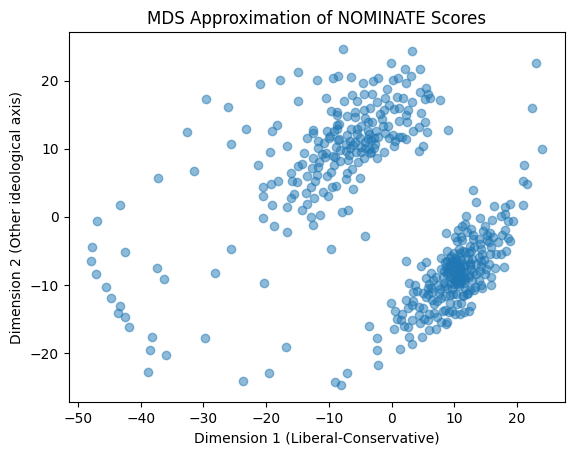

In [279]:
# Apply MDS to find ideal points in a 2D space
mds = MDS(n_components=2, dissimilarity='euclidean')
ideal_points = mds.fit_transform(sparse_matrix_us)

plt.scatter(ideal_points[:, 0], ideal_points[:, 1], alpha=0.5)
plt.xlabel("Dimension 1 (Liberal-Conservative)")
plt.ylabel("Dimension 2 (Other ideological axis)")
plt.title("MDS Approximation of NOMINATE Scores")
plt.show()


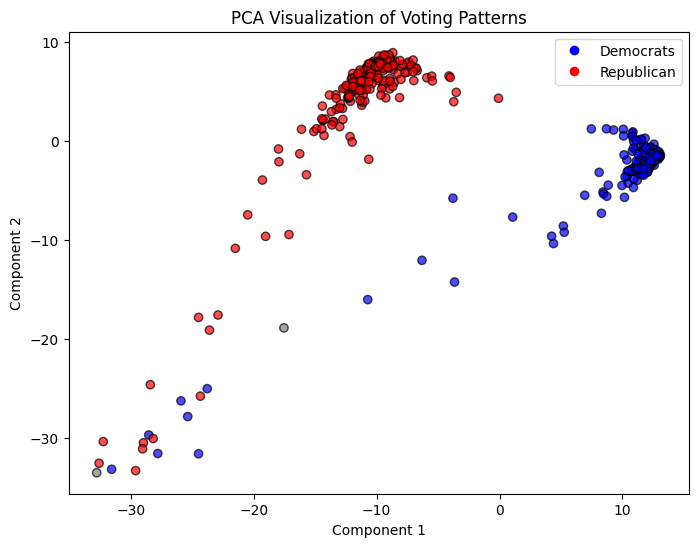

In [267]:
# Step 3: Get Party Information
person_to_party = {person: party for party, members in PP.items() for person in members}
party_colors = {100: 'blue', 200: 'red'}  # Assign colors

# Assign colors based on party
colors = [party_colors.get(person_to_party.get(person, -1), 'gray') for person in people]

# Step 4: Plot the Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(US_reduced_matrix[:, 0], US_reduced_matrix[:, 1], c=colors, alpha=0.7, edgecolors='k')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA Visualization of Voting Patterns")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Democrats'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Republican')])
plt.show()

In [268]:
mds1 = ideal_points[:,0]
mds2 = ideal_points[:,1]

In [269]:
pc1 = US_reduced_matrix[:,0]
pc2 = US_reduced_matrix[:,1]

In [270]:
pc1 = pc1*-1

In [271]:
pc1 = pc1[:-1]
pc2 = pc2[:-1]
mds1=mds1[:-1]
mds2=mds2[:-1]

In [272]:
cand = pd.read_csv("data/USA/H116_members.csv")

nom1 = cand["nominate_dim1"].dropna()
nom2 = cand["nominate_dim2"].dropna()


In [273]:
corr_score, p_value = pearsonr(pc1, nom1)
print(corr_score, p_value)
corr_score, p_value = pearsonr(pc2, nom2)
print(corr_score, p_value)

0.042336478512762454 0.3702547867534154
0.09952046102441357 0.03481376752486365


In [274]:
corr_score, p_value = pearsonr(mds1, nom1)
print(corr_score, p_value)
corr_score, p_value = pearsonr(mds2, nom2)
print(corr_score, p_value)

-0.031295851795830804 0.5078424103677569
0.04986564709525403 0.29118539487715833


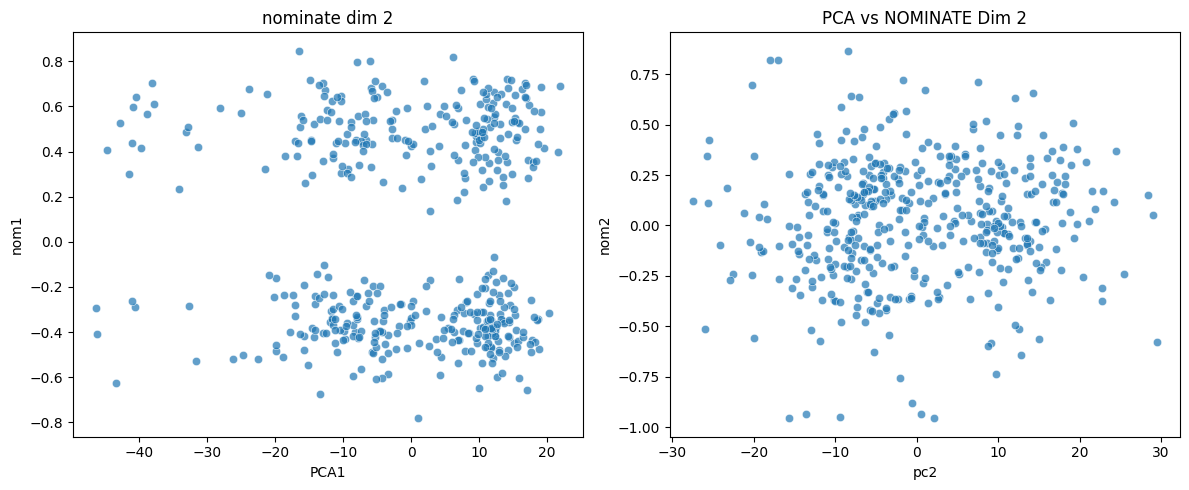

In [275]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=mds1, y=nom1, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("nom1")
axes[0].set_title("nominate dim 2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=mds2, y=nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("pc2")
axes[1].set_ylabel("nom2")
axes[1].set_title("PCA vs NOMINATE Dim 2")

plt.tight_layout()
plt.show()

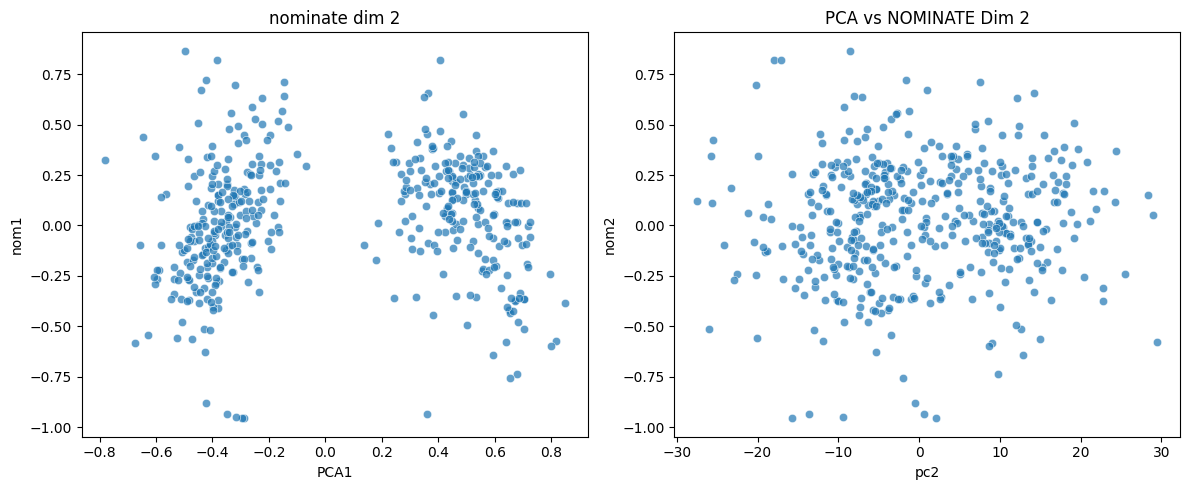

In [276]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA Dim 1 vs Nominate Dim 1
sns.scatterplot(x=nom1, y=nom2, alpha=0.7, ax=axes[0])
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("nom1")
axes[0].set_title("nominate dim 2")

# Plot PCA Dim 2 vs Nominate Dim 2
sns.scatterplot(x=mds2, y=nom2, alpha=0.7, ax=axes[1])
axes[1].set_xlabel("pc2")
axes[1].set_ylabel("nom2")
axes[1].set_title("PCA vs NOMINATE Dim 2")

plt.tight_layout()
plt.show()